## VGG Model for binary classification between Cataract (C) and Normal (N) classes

For this notebook pretained VGG16 model will be used to predict between Cataract and Normal categories.

The images have been flipped vertically so that both the right and left eyes have look similar.

### 00. Load libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 01. Load images
The images are separated into train, test and validation using the function of keras call image_dataset_from_directory

In [ ]:
train_dir = './N_C_labeled-images-flipped/train'
test_dir = './N_C_labeled-images-flipped/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 100

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 1762 files belonging to 2 classes.
Using 1410 files for training.
Found 1762 files belonging to 2 classes.
Using 352 files for validation.
Found 129 files belonging to 2 classes.


### 02. Model architecture

Loading of pretrained VGG16 model with imagenet and creating the architecture.

In [ ]:
pretrained = VGG16(weights='imagenet', include_top=False)

In [ ]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 264, 264, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               8388864   
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
 activation_1 (Activation)   (None, 1)                

### 03. Weight adjustment
As observed in the EDA, the classes were not balanced. In order for the model not to over-train, higher weights are given to those classes with fewer samples.

In [ ]:
cat_list = os.listdir('./N_C_labeled-images-flipped/train/')
cat_list.sort()

lenghts = [len(os.listdir('./N_C_labeled-images-flipped/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['C', 'N']
[262, 1500]
[2.5942243542145698, 1.0816653826391966]


### 04. Model train
We add earlystopping in order to keep the best model. If the model gets worse with increasing iterations, we will keep the best one.

For the learning_rate, a small value (0.001) is set so that the different combinations of parameters can be correctly explored until the optimum is reached.

Weights from the VGG16 model are freezed so they will not update over the training and binary crossentropy loss with Adam optimizer is used for the loss function.

The number of epochs was set at 100 in order to appreciate the evolution of the model during training.

In [ ]:
patience = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
# freeze vgg16
pretrained.trainable = False

model.compile(loss='binary_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Training
history = model.fit(
    training_generator,
    steps_per_epoch=2,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=2,
    verbose=1,
    callbacks = [early_stopping])

Epoch 1/100
2/2 [==============================] - 100s 72s/step - loss: 4.3920 - accuracy: 0.8750 - val_loss: 6.6926 - val_accuracy: 0.7969
Epoch 2/100
2/2 [==============================] - 94s 71s/step - loss: 2.2574 - accuracy: 0.8750 - val_loss: 10.4383 - val_accuracy: 0.2031
Epoch 3/100
2/2 [==============================] - 93s 70s/step - loss: 4.7897 - accuracy: 0.5625 - val_loss: 2.6459 - val_accuracy: 0.7656
Epoch 4/100
2/2 [==============================] - 94s 70s/step - loss: 1.2157 - accuracy: 0.9062 - val_loss: 4.0508 - val_accuracy: 0.7969
Epoch 5/100
2/2 [==============================] - 93s 70s/step - loss: 3.7042 - accuracy: 0.7969 - val_loss: 2.1602 - val_accuracy: 0.8125
Epoch 6/100
2/2 [==============================] - 92s 69s/step - loss: 0.1903 - accuracy: 0.9688 - val_loss: 0.2164 - val_accuracy: 0.9844
Epoch 7/100
2/2 [==============================] - 91s 68s/step - loss: 0.3110 - accuracy: 0.9688 - val_loss: 0.9330 - val_accuracy: 0.8438
Epoch 8/100
2/2 [=

In [ ]:
model.save('vgg16_binary_cataract_normal.h5')

### 05. Analysis of results

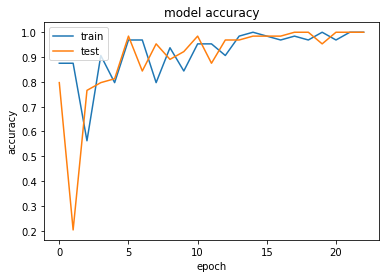

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The accuracy evolves positively throughout the training period resulting in values close to 1 providing a model with very good results.

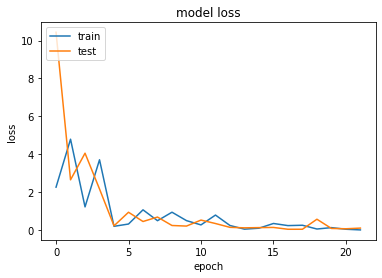

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In the case of loss, it is observed that as the epochs increase, their value decreases gradually until it flats, which is good for the model precision.

In [ ]:
model = load_model('vgg16_binary_cataract_normal.h5')

In [ ]:
## Predict on test data
y_pred = model.predict(test_generator)

In [ ]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [ ]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

Text(33.0, 0.5, 'Truth')

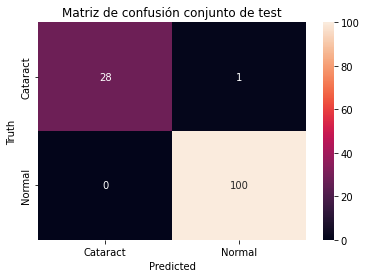

In [ ]:
cf_matrix = confusion_matrix(y_real, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.title('Matriz de confusión conjunto de test')
ax.xaxis.set_ticklabels(['Cataract','Normal'])
ax.yaxis.set_ticklabels(['Cataract','Normal'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

The confusion matrix for the test set is almost perfect, only missclassifies one Cataract sample, resulting in almost 100% accuracy for both classes. This model passes the test filter and could be considered for production.

In [ ]:
print(classification_report(y_real, y_pred, target_names=['Cataract','Normal']))

              precision    recall  f1-score   support

    Cataract       1.00      0.97      0.98        29
      Normal       0.99      1.00      1.00       100

    accuracy                           0.99       129
   macro avg       1.00      0.98      0.99       129
weighted avg       0.99      0.99      0.99       129

